# Scientific ML Project: Text Summarization

## Install & Import Dependencies

In [14]:
%pip install datasets -U
%pip install accelerate -U
%pip install rouge_score
%pip install bert_score
%pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.1/385.1 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 MB 45.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from datasets import load_dataset, load_metric
import pandas as pd
import accelerate
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, EarlyStoppingCallback, IntervalStrategy, BartForConditionalGeneration, BartTokenizer

## Load Dataset

In [2]:
dataset = load_dataset("scientific_papers", 'pubmed')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for scientific_papers contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scientific_papers
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## Clean Dataset

In [3]:
# Define a function to calculate the length of each article
def calculate_length(example):
    # Split the article into words and calculate the length
    return {'length': len(example['article'].split())}

# Apply the function to the dataset
dataset_with_lengths = dataset.map(calculate_length)

# Convert the 'length' column to a list to calculate the IQR
lengths = dataset_with_lengths['train']['length']+dataset_with_lengths['validation']['length']+dataset_with_lengths['test']['length']

# Calculate the quartiles and IQR
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Define a function to filter out outliers
def filter_outliers(example):
    # Check if the article length is within the IQR bounds
    return lower_bound <= example['length'] <= upper_bound

# Filter the dataset to remove outliers
filtered_dataset = dataset_with_lengths.filter(filter_outliers)

## Split Dataset

In [4]:
# Load the PubMed dataset
train_dataset = filtered_dataset['train'].shuffle().take(10000)
valid_dataset = filtered_dataset['validation'].shuffle().take(1000)
test_dataset = filtered_dataset['test']

## T5 Small Model

In [4]:
# Load the tokenizer and model from the T5 family
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Preprocess the data
def preprocess_function(examples):
    inputs = [doc for doc in examples['article']]
    model_inputs = tokenizer(inputs, max_length=512, padding='max_length', truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['abstract'], padding='max_length', max_length=512, truncation=True)

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_tokenized_datasets = train_dataset.map(preprocess_function, batched=True)
valid_tokenized_datasets = valid_dataset.map(preprocess_function, batched=True)
test_tokenized_datasets = test_dataset.map(preprocess_function, batched=True)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [6]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=5e-5,
    logging_steps=100,
    save_steps=100,
    eval_steps = 100,
    save_total_limit = 3,
    load_best_model_at_end=True,
    evaluation_strategy = IntervalStrategy.STEPS,
    metric_for_best_model="eval_loss", 
    greater_is_better=False
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=valid_tokenized_datasets,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Step,Training Loss,Validation Loss
100,2.809800,2.162514
200,2.542100,2.043223
300,2.253000,1.959779
400,2.110200,1.902086
500,2.090100,1.862162
600,1.997600,1.838754
700,2.018000,1.815726
800,1.964400,1.802646
900,1.960000,1.787469
1000,1.957900,1.778232


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=3750, training_loss=1.9457066609700522, metrics={'train_runtime': 1973.0723, 'train_samples_per_second': 15.205, 'train_steps_per_second': 1.901, 'total_flos': 4060254044160000.0, 'train_loss': 1.9457066609700522, 'epoch': 3.0})

In [7]:
trainer.save_model("./model")

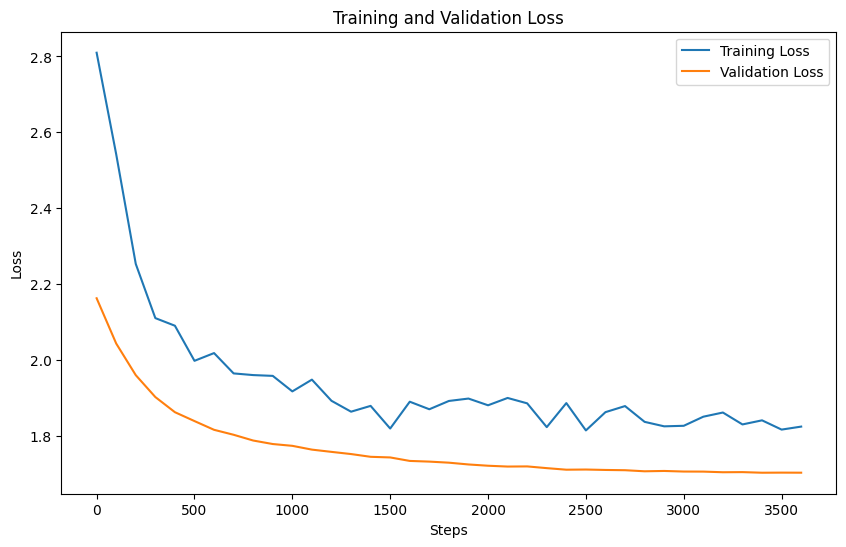

In [14]:
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Generate steps for x-axis
steps = (range(len(training_loss)))
steps = list(map(lambda x: x * 100, steps))

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label='Training Loss')
plt.plot(steps, validation_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [7]:
model_path="./model"
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained(model_path, device_map = 'cuda')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
# Assuming you've already loaded the trained model and tokenizer
input_text = "great progress has been made in neonatal care over the last few decades , reflected by improving survival rates and clinical outcomes of preterm infants . despite these advances , 45 years after its first description , bronchopulmonary dysplasia ( bpd ) remains a major complication of premature birth , causing ongoing morbidity and mortality : it is the most common neonatal chronic lung disease , affecting around 25% to 35% of vlbw neonates ( very low birth weight , < 1500 g ) , and is associated with increased risk for rehospitalization [ 3 , 4 ] , cognitive delay , and neurosensory deficits . initially described by northway et al . in 1967 , the old bpd mainly affected modestly premature newborns suffering from respiratory distress and therefore mechanically ventilated with high levels of supplemental oxygen . with the introduction of surfactant treatment , prenatal maternal use of glucocorticoids , improved nutrition , and ventilator strategies the clinical course and pathology of bpd have changed considerably . unlike the original description , today 's new bpd is mainly regarded as a disruption of distal lung growth [ 6 , 7 ] . thus , influenced by both genetic susceptibility [ 8 , 9 ] and environmental factors on the immature lung , the pathophysiology is characterized by inflammation , abnormal microvascularization , and impaired alveolarization . alveolar formation of the primitive saccules is a complex process of epithelial morphogenesis , capillary growth , and coordinated extracellular matrix ( ecm ) remodelling . at this , fibroblast growth factor ( fgf ) signalling and matrix metalloproteinase ( mmp ) activity play eminent roles . some mmps are upregulated in inflammatory environment and yet are involved in pulmonary host defense . there is evidence for some mmp isoforms being important determinants for alveolarization , especially mmp-2 , -9 , and -16 : mmp-2 deficient mice showed fewer and larger alveoli with thinner interstitial tissue . hadchouel et al . demonstrated an increase of mmp-16 activity during the alveolar stage and moreover found two snps within the mmp-16 gene being associated with lower tracheal mmp-2 and -16 activity and to protect from bpd . prospecting further potential biomarkers for bpd , also mmp-9 shows some promise ; for example , harijith et al . highlighted a mmp-9-dependent lung injury pathway in an ifn-mediated animal model of bpd . mice with a partial mmp-9 deficiency showed a reversal of ifn-induced lung injury during hyperoxia . mmps , particularly mmp-2 and -9 , activate fibroblast growth factors ( fgfs ) by cleavage in the ecm , especially during angiogenesis . in turn activated fgfs upregulate mmp expression . fgfs are secreted glycoproteins involved in interactions between epithelium and mesenchyme regulating cell migration and proliferation in embryonic development , especially in fetal pulmogenesis [ 16 , 17 ] . their signalling depends on membrane - located receptors ( fgfrs ) with a tyrosine kinase domain , encoded by four different genes ( fgfr 14 ) [ 1820 ] . they are all translated in developing lungs and are suggested to play major roles in modifying distal lung patterns during alveolarization ; for example , fgfr-3-fgfr-4 double - knockout mice show no alveolarization . it has been assumed that heritable determinants contribute significantly to both bpd [ 8 , 23 ] and rds . on this account , we were interested in identifying genetic risk factors in a caucasian population of premature newborn with bpd and rds . we genotyped 27 polymorphisms within fourteen candidate genes for bpd : mmp-1 , -2 , -9 , -12 , and -16 , fgf receptors 2 and 4 , fgf-2 , -3 , -4 , -7 , and -18 , signal - regulatory protein ( sirpa ) , and thyroid transcription factor-1 ( ttf-1 ) . we also included sirpa because of the known effect on surfactant proteins and inhibition of macrophages , as well as ttf-1 due to its effect on lung differentiation . we recruited preterm neonates ( 28 weeks of gestation ) born between january 1996 and september 2010 at the centre for pediatrics and adolescent medicine , university hospital freiburg , germany . twins and siblings were excluded from the study as were children with chromosomal aberrations , congenital heart defects , or other major congenital malformations . dna was collected by buccal swabs or by routine blood sampling , between 2 weeks up to 2 years of age . this included gestational week , number of days with supplemental oxygen , need of mechanical ventilation and positive airway pressure , and need of surfactant therapy . as described previously , the subdivision of our bpd study population was based on the analysis by lavoie et al . about the heritability of bpd according to the consensus defined by the national institute of health : the bpd population included all infants with moderate and severe bpd , that is , supplemental oxygen for at least 28 days plus need of oxygen and/or positive pressure at 36 weeks of gestation , whereas the control population consisted of all preterm neonates with no or mild bpd . recruiting neonates for the rds population was targeted on severe cases of respiratory distress by including only newborns depending on surfactant within the first 24 hours after birth ( see supplementary material available online at http://dx.doi.org/10.1155/2013/932356 ) . at our neonatal intensive care unit ( nicu ) the following approach has been applied regarding the treatment with surfactant : avoiding of intubation independent of the gestational week . therefore , even very premature infants are only intubated if they show failure of ventilation and/or need of supplemental oxygen above 40% . once they required intubation during the immediate postnatal period , they receive surfactant within 2 hours . we included a minority of polymorphisms that already had been tested for other pathologies ( rs1799750 in mmp1 and rs2276109 and rs652438 in mmp12 ) . for pcr reactions , genomic dna was initially denatured at 94c for 5 minutes and underwent 3540 cycles of denaturation ( 94c for 30 seconds ) , annealing ( 1 minute , corresponding temperatures displayed in table 2 ) , extension reaction ( 72c for 1 minute ) , and a final extension step at 72c for 8 minutes . in table 2 some primers contain intended single nucleotide mismatches ( mutagenic primers ) to create sites for restriction enzymes . accuracy of the rflp was confirmed by sequencing via dideoxy chain termination method , respectively , three controls ( homozygous wildtype , heterozygous , and homozygous mutation ) for each polymorphism using the big dye terminator cycle sequencing kit on an abi 310 sequencer ( applied biosystems ) . genotyping data of our case - control populations were analysed by using armitage 's trend test ( att ) for possible association with bpd and rds as specified previously . moreover att was used to calculate hardy weinberg equilibrium ( hwe ) for each polymorphism . the collection of blood / buccal swabs and the experimental procedures were approved by the ethical committee of the university of freiburg . parents were given written and verbal information about the study and a statement of informed consent was signed by the parents of all enrolled children . the results of the 27 studied polymorphisms ( table 1 ) for association with bronchopulmonary dysplasia and neonatal respiratory distress are specified in table 3 ( bpd ) and table 4 ( rds ) . among the 11 genotyped polymorphisms in different mmp genes ( see table 1 ) there was no bpd - associated polymorphism ( table 3 ) but two polymorphisms associated ( p < 0.05 ) with rds ( rs20544 in mmp-9 : p = 0.033 ; rs652438 in mmp-12 : p = 0.047 , see table 4 ) . both snps show no significant deviation from hardy - weinberg equilibrium , neither in the control nor in the case population . analysis of rs20544 ( c / t ) identifies the t allele as protective against respiratory distress . for the genotyping results of the amino acid substitution rs652438 ( a / g , asn357ser ) the complete absence of the g / g homozygous genotype in the respiratory distress case population must be taken in account . the other mmp - snps showed no association , inclusively rs2664352 in mmp16 , that had been associated with protection from bpd . the fgfr-4 snp rs1966265 , located in the exon region and causing an amino acid substitution of isoleucine ( ile ) for valine ( val ) is associated with both bpd ( p = 0.023 ) and rds ( p = 0.003 ) . here the a / a genotype ( ile ) could be identified as protective allele variant against our studied lung diseases . the association results from significant differences in allele frequencies : in both bpd and rds analysis the g allele is more frequent in the disease populations ( see tables 3 and 4 ) . the other snps in the fgfr genes showed no association with neither bpd nor respiratory distress . whereas no association could be detected between the eight fgf - snps and bpd , rs10796856 in fgf-3 and rs4316697 in fgf-7 showed associations with rds . correspondent p values are p = 0.036 ( rs10796856 ) and p = 0.044 ( rs4316697 ) , and no deviations from hardy - weinberg equilibrium were detected ( see table 4 ) . the four snps in sirpa and ttf-1 showed no association with neither bpd nor rds . analysis of ttf-1 rs999460 unfolds deviation from hardy - weinberg equilibrium in both case and one control populations in our caucasian population ( see tables 3 and 4 ) . the aim of this study has been to identify genetic risk factors in an ethnically homogenous caucasian population . genetic contribution to bpd is suggested on the basis of twin studies demonstrating that at least half of the susceptibility is hereditary [ 8 , 9 , 23 ] . additionally , lavoie et al . could differentiate in their study that mild bpd ( according to the national institute of child health and human development consensus definition ) had been mainly attributable to shared environmental factors whereas moderate or severe bpd had been attributable to genetic influence . following these findings , we defined our control population as neonates with no bpd or mild bpd , whereas our bpd population included neonates with moderate or severe bpd . furthermore , we recruited only preterm neonates 28 weeks of gestational age for the bpd population to avoid false associations based on the fact that bpd hardly develops in newborn older than 30 weeks of gestational age . in contrast to bpd , the results of twin studies on rds susceptibility showed mostly contradictory results [ 24 , 3235 ] . a twin study by levit et al . with 332 twin pairs of a heterogeneous population has been the first one to include and assess the influence of several independent covariates , revealing that 50% of the variance to rds susceptibility is hereditary . given these lines of evidence for genetic contribution , we have chosen the candidate - gene approach for our association study based on the hypothesis that genes fundamental in lung organogenesis and alveolar remodelling , that is , mmp and fgf , determine susceptibility to bpd and rds . known genetic risk factors for rds are mostly allelic polymorphisms of the genes encoding surfactant proteins sp - a1 , sp - a2 , and sp - b . anyhow , other determinants than components of the surfactant system might also affect the liability to rds . genes encoding for growth factors or enzymes that account for alveolarization through proper secondary septation and extracellular remodeling might affect the gas - exchange and therefore aggravate respiratory distress at birth . supposed genetic risk factors for bpd are mostly genes encoding components of innate immunity and antigen - presentation , cytokines , antioxidant defences , and angiogenic growth factors such as : mannose - binding lectin ( mbl2 ) , tumor necrosis factor - alpha ( tnf- ) [ 28 , 38 ] , human leucocyte antigen ( hla)-a , -b , and -c alleles , glutathione - s - transferase - p1 , and vascular endothelial growth factor ( vegf ) . some years ago , two mmp-16 gene polymorphisms were demonstrated to protect from bpd and moreover to be associated with lower tracheal mmp-2 and -16 levels . matrix metalloproteinases are a family of zinc - dependent endopeptidases , and they degrade extracellular components and play a crucial role in lung development , especially during alveolarization . particularly mmp-2 and -9 ( so - called gelatinases a and b ) seem to be relevant in extracellular remodeling and even pulmonary host defense . they degrade type iv collagen , fibronectin , elastin , and denatured collagen ( gelatin ) . mmp-2 deficient mice show an abnormal saccular development with larger and simplified alveoles . in line with this finding , newborns developing bpd showed low mmp-2 tracheal levels at birth [ 41 , 42 ] . recently , mmp-9 could be identified as a pathogenic key mediator in a murine model of bpd . on the other hand , increased tracheal levels of mmp-9 early after birth have been associated with resolving rds , suggesting that increase in mmp-9-activity is a physiologic repair response . demonstrated that increased mmp-9 activity in neonatal lungs early after birth correlated with resolving respiratory distress syndrome , demonstrating a likely role of mmp-9 in pulmonary host defense . in our study we identified an snp ( rs20544 ) in the mmp-9 gene to be associated ( p = 0.033 ) with rds , but not bpd . respiratory distress syndrome has been defined as need of surfactant ( see supplementary material ) . on one hand , ethnically homogenous populations like our caucasian population are favourable to detect possible pathogenetic determinants , but one must bear in mind that the size of our rds population is limited and the total numbers of neonates studied for each polymorphism vary slightly according to the recruiting time point . furthermore , association studies on rds are prone to confounding factors . other pulmonary conditions such as a transient tachypnea provoked by wet lung syndrome or pulmonary infection might mimic respiratory distress syndrome caused by surfactant deficiency and thereby hamper the results of our study . in our study , we included mmp-16 polymorphisms that had been associated with bpd in a french population ( rs2664352 ) . in our population rs2664352 up to now , the role of fgf3 has been mainly studied in cancer diseases , that is , lung cancer , but its exact role in pulmogenesis remains elusive . there is evidence for fgf-3 upregulation to be associated with alveolar type 2 cell hyperplasia and downregulation to be associated with an excessive recruitment of free alveolar macrophages which might lead to symptoms of respiratory distress . furthermore it has been shown that fgf-3 stimulates the secretion of mmp-2 and -9 propeptides in vitro . fgfr-4 polymorphism rs1966265 showed association with both respiratory distress ( p = 0.003 ) and bronchopulmonary dysplasia ( p = 0.023 ) . the a / a genotype ( encoding for isoleucin instead of valine ) has been protective in our association study . the exact - test showed no deviation from hardy weinberg equilibrium for this snp in both case and control populations , suggesting that the association does not result from population admixture or genotyping errors . fgfr-1 to fgfr-4 are expressed in the lung and fgfr-3 and -4 signalling , in particular , appears to be fundamental in alveolar formation . weinstein et al . demonstrated that mice deficient in both fgfr-3 and -4 show a completely blocked alveolarization and fail to show any formation of secondary septae , whereas solely fgfr-4(/ ) animals exhibit no significant abnormalities , revealing a cooperative effect of fgfr-3 and -4 in lung development . hyperoxia - exposed ( fio2 0.85 ) mice show a bpd - like lung pattern of enlarged airspaces and furthermore a reduced expression of fgfr-3 and -4 , suggesting a pathogenic role in arrested lung development . replicated these results in fgfr-3 and -4 deficient mice and demonstrated in addition that fgfr-3/-4 signaling contributes to excessive elastin production and its alveolar accumulation , which is another typical feature of bpd . but these abnormalities have not been due to fibroblast defects but due to increased expression of paracrine factors of alveolar type 2 cell ( at2 ) . if a reduction in fgfr-3 and -4 expression affects distal lung development , a functionally significant polymorphism within the correspondent gene possibly alters the susceptibility to alveolar disease such as bpd and rds . showed that there is a peak of fgfr-4 expression at the day of birth , when respiratory distress syndrome occurs . false - positive results can only be excluded by replications in other study populations . in conclusion , we describe five snps in mmp-9 , mmp-12 , fgfr-4 , fgf-3 , and fgf-7 that are associated ( p < 0.05 ) in our caucasian population with respiratory distress syndrome of the newborn , defined as surfactant application within the first 24 hours after birth . among these polymorphisms one polymorphism in fgfr-4 ( rs1966265 ) is additionally associated with bronchopulmonary dysplasia , demonstrating its possible role in the pathogenesis of newborn lung diseases on grounds of pulmonal immaturity ."

# Tokenize and preprocess the input
inputs = tokenizer(input_text, max_length=512, padding='max_length', truncation=True, return_tensors='pt')

# Move the input tensors to the same device as the model
inputs = inputs.to(model.device)

# Generate summaries
with torch.no_grad():
    summary_ids = model.generate(inputs['input_ids'], num_beams=10, max_length=512, early_stopping=True)

# Decode the summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:", summary)

Generated Summary: bronchopulmonary dysplasia ( bpd ) remains a major complication of premature birth. despite these advances, 45 years after its first description, the old bpd is mainly affected modestly premature newborns suffering from respiratory distress and therefore mechanically ventilated with high levels of supplemental oxygen. despite this advances, 45 years after its first description, prenatal maternal use of glucocorticoids, improved nutrition, and ventilator strategies the clinical course and pathology of bronchopulmonary dysplasia isoforms are important determinants for alveolarization.


### Summary Comparision

Generated Summary: bronchopulmonary dysplasia ( bpd ) remains a major complication of premature birth. despite these advances, 45 years after its first description, the old bpd is mainly affected modestly premature newborns suffering from respiratory distress and therefore mechanically ventilated with high levels of supplemental oxygen. despite this advances, 45 years after its first description, prenatal maternal use of glucocorticoids, improved nutrition, and ventilator strategies the clinical course and pathology of bronchopulmonary dysplasia isoforms are important determinants for alveolarization.



Actual: background . bronchopulmonary dysplasia ( bpd ) is the most common chronic lung disease of premature birth , characterized by impaired alveolar development and inflammation . pathomechanisms contributing to bpd are poorly understood . however , it is assumed that genetic factors predispose to bpd and other pulmonary diseases of preterm neonates , such as neonatal respiratory distress syndrome ( rds ) . for association studies , genes upregulated during alveolarization are major candidates for genetic analysis , for example , matrix metalloproteinases ( mmps ) and fibroblast growth factors ( fgfs ) and their receptors ( fgfr ) . objective . determining genetic risk variants in a caucasian population of premature neonates with bpd and rds . methods . we genotyped 27 polymorphisms within 14 candidate genes via restriction fragment length polymorphism ( rflp ) : mmp-1 , -2 , -9 , and -12 , -16 , fgf receptors 2 and 4 , fgf-2 , -3 , -4 , -7 , and -18 , signal - regulatory protein ( sirpa ) and thyroid transcription factor-1 ( ttf-1 ) . results . five single nucleotide polymorphisms ( snps ) in mmp-9 , mmp-12 , fgfr-4 , fgf-3 , and fgf-7 are associated ( p < 0.05 ) with rds , defined as surfactant application within the first 24 hours after birth . one of them , in fgfr-4 ( rs1966265 ) , is associated with both rds ( p = 0.003 ) and bpd ( p = 0.023 ) . conclusion . rs1966265 in fgf receptor 4 is a possible genetic key variant in alveolar diseases of preterm newborns .

In [19]:
# Define the training arguments for evaluation
eval_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=100,
)

# Initialize the Trainer for evaluation
eval_trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=test_tokenized_datasets,
    tokenizer=tokenizer
)

# Evaluate the model on the test dataset
metrics = eval_trainer.evaluate()

# Print the evaluation metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

eval_loss: 1.71560537815094
eval_runtime: 92.1858
eval_samples_per_second: 69.794
eval_steps_per_second: 4.372


In [20]:
# Load the metrics
rouge = load_metric('rouge')
bleu = load_metric('bleu')
bertscore = load_metric('bertscore')
meteor = load_metric('meteor')

# Function to generate summaries and compute metrics
def compute_metrics(eval_dataset):
    summaries = []
    references = []

    # Generate summaries
    for num,batch in enumerate(eval_dataset):
        print("On summary #",num)
        inputs = tokenizer(batch['article'], return_tensors='pt', padding=True, truncation=True, max_length=512)

        # Move the input tensors to the same device as the model
        inputs = inputs.to(model.device)

        summaries_ids = model.generate(inputs['input_ids'], max_length=512, num_beams=4, early_stopping=True)
        summaries.append(tokenizer.decode(summaries_ids[0], skip_special_tokens=True))
        references.append(batch['abstract'])

    # Compute ROUGE
    rouge_score = rouge.compute(predictions=summaries, references=references)

    # Compute BLEU
    # Note: BLEU requires tokenized sentences
    tokenized_summaries = [tokenizer.tokenize(summary) for summary in summaries]
    tokenized_references = [[tokenizer.tokenize(ref)] for ref in references]  # BLEU expects a list of references
    bleu_score = bleu.compute(predictions=tokenized_summaries, references=tokenized_references)

    # Compute BERTScore
    bertscore_score = bertscore.compute(predictions=summaries, references=references, lang='en')

    # Compute METEOR
    meteor_score = meteor.compute(predictions=summaries, references=references)

    return {
        'rouge': rouge_score,
        'bleu': bleu_score,
        'bertscore': bertscore_score,
        'meteor': meteor_score
    }

# Compute metrics for the test dataset
metrics = compute_metrics(test_tokenized_datasets.take(100))

# Print the evaluation metrics
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will 

On summary # 0
On summary # 1
On summary # 2
On summary # 3
On summary # 4
On summary # 5
On summary # 6
On summary # 7
On summary # 8
On summary # 9
On summary # 10
On summary # 11
On summary # 12
On summary # 13
On summary # 14
On summary # 15
On summary # 16
On summary # 17
On summary # 18
On summary # 19
On summary # 20
On summary # 21
On summary # 22
On summary # 23
On summary # 24
On summary # 25
On summary # 26
On summary # 27
On summary # 28
On summary # 29
On summary # 30
On summary # 31
On summary # 32
On summary # 33
On summary # 34
On summary # 35
On summary # 36
On summary # 37
On summary # 38
On summary # 39
On summary # 40
On summary # 41
On summary # 42
On summary # 43
On summary # 44
On summary # 45
On summary # 46
On summary # 47
On summary # 48
On summary # 49
On summary # 50
On summary # 51
On summary # 52
On summary # 53
On summary # 54
On summary # 55
On summary # 56
On summary # 57
On summary # 58
On summary # 59
On summary # 60
On summary # 61
On summary # 62
On

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge: {'rouge1': AggregateScore(low=Score(precision=0.3873600296820049, recall=0.22224266766958853, fmeasure=0.27121431833849535), mid=Score(precision=0.41372738672577647, recall=0.24552171974958914, fmeasure=0.2911503387548896), high=Score(precision=0.44080036122478233, recall=0.26764516494641355, fmeasure=0.3110759707377093)), 'rouge2': AggregateScore(low=Score(precision=0.11267741043517537, recall=0.065527290999156, fmeasure=0.07930893306719469), mid=Score(precision=0.13224082766806286, recall=0.08036604804855338, fmeasure=0.09436655762740934), high=Score(precision=0.15184549426892524, recall=0.09837703292764075, fmeasure=0.11209732205369131)), 'rougeL': AggregateScore(low=Score(precision=0.24328973840532814, recall=0.14202706936156867, fmeasure=0.1699309039533116), mid=Score(precision=0.2626777456835211, recall=0.15837001993934002, fmeasure=0.18582567148816115), high=Score(precision=0.28244770436475947, recall=0.17811824949466523, fmeasure=0.20331979739030606)), 'rougeLsum': Aggre

### T5-small Score Explanation

Interpretation:
- Your ROUGE scores suggest that there is a reasonable amount of word overlap between the generated and reference summaries, with better performance on individual words (ROUGE-1) than on pairs of words (ROUGE-2).
- The BLEU score is quite low, which might indicate that the generated summaries are not very close to the reference summaries in terms of precise word sequences.
- The BERTScore results seem quite high, suggesting that the generated summaries are semantically similar to the reference summaries.
- The METEOR score is also relatively low, which, like the BLEU score, suggests that there might be room for improvement in the exact matching of content and order of words.

In summary, your model seems to capture the gist of the reference summaries reasonably well semantically, as indicated by the BERTScore, but it may struggle with producing exact word sequences that match the reference summaries, as indicated by the BLEU and METEOR scores. Improving the model might involve fine-tuning with a larger dataset, adjusting the model architecture, or post-processing the generated summaries for better word choice and ordering.

## BART Model

In [7]:
# Initialize the BART tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Preprocess the data
def preprocess_function(examples):
    # Encode the inputs and targets
    model_inputs = tokenizer(examples['article'], padding='max_length', max_length=1024, truncation=True)
    # Set up the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['abstract'], padding='max_length', max_length=1024, truncation=True)

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Apply the preprocessing function to the dataset
bart_train_tokenized_datasets = train_dataset.map(preprocess_function, batched=True)
bart_valid_tokenized_datasets = valid_dataset.map(preprocess_function, batched=True)
bart_test_tokenized_datasets = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    learning_rate=5e-5,
    save_steps=100,
    eval_steps = 100,
    save_total_limit = 3,
    load_best_model_at_end=True,
    evaluation_strategy = IntervalStrategy.STEPS,
    metric_for_best_model="eval_loss", 
    greater_is_better=False
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=bart_train_tokenized_datasets,
    eval_dataset=bart_valid_tokenized_datasets,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

Step,Training Loss,Validation Loss
100,8.166200,4.130275
200,3.234600,1.278233
300,1.048700,0.699513
400,0.788300,0.666668
500,0.730800,0.653119
600,0.759400,0.643301
700,0.740900,0.646516
800,0.722300,0.629583
900,0.711500,0.625032
1000,0.691600,0.619227


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=3750, training_loss=0.9360710825602213, metrics={'train_runtime': 6692.7656, 'train_samples_per_second': 4.482, 'train_steps_per_second': 0.56, 'total_flos': 1.82920937472e+16, 'train_loss': 0.9360710825602213, 'epoch': 3.0})

In [8]:
trainer.save_model("./bart-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


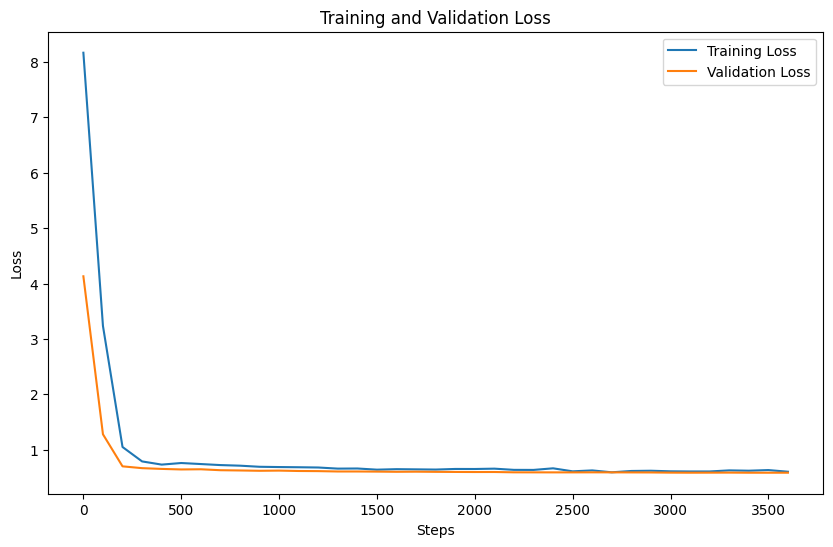

In [10]:
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Generate steps for x-axis
steps = (range(len(training_loss)))
steps = list(map(lambda x: x * 100, steps))

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label='Training Loss')
plt.plot(steps, validation_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [9]:
# Tokenize and preprocess the input
inputs = tokenizer(input_text, max_length=1024, padding='max_length', truncation=True, return_tensors='pt')

# Move the input tensors to the same device as the model
inputs = inputs.to(model.device)

# Generate summaries
with torch.no_grad():
    summary_ids = model.generate(inputs['input_ids'], num_beams=10, max_length=1024, early_stopping=True)

# Decode the summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:", summary)

Generated Summary:  background and objectives : bronchopulmonary dysplasia ( bpd ) remains a major complication of premature birth, causing ongoing morbidity and mortality. 
 the purpose of this study was to identify genetic risk factors in a caucasian population of premature newborn with bpd and rds.materials and methods : we genotyped 27 polymorphisms within fourteen candidate genes for bpd : mmp-1, -2, -9, -12, and -16, fibroblast growth factor ( fgf ), -3, -4, -7, -18, and matrix metalloproteinase ( mmp -9 ), which are important determinants for alveolarization in developing lungs and to protect from bpd.results:a total of 27 genotypes of bpd were identified, with a mean age ranging from 2 to 28 weeks of gestation ( p < 0.001 ). of the genotypes, 
 there was a significant association between mmp2 and -9 ( p = 0.002 ) and bpd. in addition, there was no association between bpd or rds. 


### Summary Comparision
Generated Summary: background and objectives : bronchopulmonary dysplasia ( bpd ) remains a major complication of premature birth, causing ongoing morbidity and mortality. the purpose of this study was to identify genetic risk factors in a caucasian population of premature newborn with bpd and rds.materials and methods : we genotyped 27 polymorphisms within fourteen candidate genes for bpd : mmp-1, -2, -9, -12, and -16, fibroblast growth factor ( fgf ), -3, -4, -7, -18, and matrix metalloproteinase ( mmp -9 ), which are important determinants for alveolarization in developing lungs and to protect from bpd.results:a total of 27 genotypes of bpd were identified, with a mean age ranging from 2 to 28 weeks of gestation ( p < 0.001 ). of the genotypes, there was a significant association between mmp2 and -9 ( p = 0.002 ) and bpd. in addition, there was no association between bpd or rds.

Actual Summary: background . bronchopulmonary dysplasia ( bpd ) is the most common chronic lung disease of premature birth , characterized by impaired alveolar development and inflammation . pathomechanisms contributing to bpd are poorly understood . however , it is assumed that genetic factors predispose to bpd and other pulmonary diseases of preterm neonates , such as neonatal respiratory distress syndrome ( rds ) . for association studies , genes upregulated during alveolarization are major candidates for genetic analysis , for example , matrix metalloproteinases ( mmps ) and fibroblast growth factors ( fgfs ) and their receptors ( fgfr ) . objective . determining genetic risk variants in a caucasian population of premature neonates with bpd and rds . methods . we genotyped 27 polymorphisms within 14 candidate genes via restriction fragment length polymorphism ( rflp ) : mmp-1 , -2 , -9 , and -12 , -16 , fgf receptors 2 and 4 , fgf-2 , -3 , -4 , -7 , and -18 , signal - regulatory protein ( sirpa ) and thyroid transcription factor-1 ( ttf-1 ) . results . five single nucleotide polymorphisms ( snps ) in mmp-9 , mmp-12 , fgfr-4 , fgf-3 , and fgf-7 are associated ( p < 0.05 ) with rds , defined as surfactant application within the first 24 hours after birth . one of them , in fgfr-4 ( rs1966265 ) , is associated with both rds ( p = 0.003 ) and bpd ( p = 0.023 ) . conclusion . rs1966265 in fgf receptor 4 is a possible genetic key variant in alveolar diseases of preterm newborns .

In [8]:
model_path="./bart-model"
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained(model_path, device_map = 'cuda')

In [10]:
# Load the metrics
rouge = load_metric('rouge')
bleu = load_metric('bleu')
bertscore = load_metric('bertscore')
meteor = load_metric('meteor')

# Function to generate summaries and compute metrics
def compute_metrics(eval_dataset):
    summaries = []
    references = []

    # Generate summaries
    for num,batch in enumerate(eval_dataset):
        print("On summary #",num)
        inputs = tokenizer(batch['article'], return_tensors='pt', padding=True, truncation=True, max_length=1024)

        # Move the input tensors to the same device as the model
        inputs = inputs.to(model.device)

        summaries_ids = model.generate(inputs['input_ids'], max_length=1024, num_beams=10, early_stopping=True)
        summaries.append(tokenizer.decode(summaries_ids[0], skip_special_tokens=True))
        references.append(batch['abstract'])

    # Compute ROUGE
    rouge_score = rouge.compute(predictions=summaries, references=references)

    # Compute BLEU
    # Note: BLEU requires tokenized sentences
    tokenized_summaries = [tokenizer.tokenize(summary) for summary in summaries]
    tokenized_references = [[tokenizer.tokenize(ref)] for ref in references]  # BLEU expects a list of references
    bleu_score = bleu.compute(predictions=tokenized_summaries, references=tokenized_references)

    # Compute BERTScore
    bertscore_score = bertscore.compute(predictions=summaries, references=references, lang='en')

    # Compute METEOR
    meteor_score = meteor.compute(predictions=summaries, references=references)

    return {
        'rouge': rouge_score,
        'bleu': bleu_score,
        'bertscore': bertscore_score,
        'meteor': meteor_score
    }

# Compute metrics for the test dataset
metrics = compute_metrics(bart_test_tokenized_datasets.take(100))

# Print the evaluation metrics
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

/tmp/ipykernel_6972/3324828816.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly 

On summary # 0
On summary # 1
On summary # 2
On summary # 3
On summary # 4
On summary # 5
On summary # 6
On summary # 7
On summary # 8
On summary # 9
On summary # 10
On summary # 11
On summary # 12
On summary # 13
On summary # 14
On summary # 15
On summary # 16
On summary # 17
On summary # 18
On summary # 19
On summary # 20
On summary # 21
On summary # 22
On summary # 23
On summary # 24
On summary # 25
On summary # 26
On summary # 27
On summary # 28
On summary # 29
On summary # 30
On summary # 31
On summary # 32
On summary # 33
On summary # 34
On summary # 35
On summary # 36
On summary # 37
On summary # 38
On summary # 39
On summary # 40
On summary # 41
On summary # 42
On summary # 43
On summary # 44
On summary # 45
On summary # 46
On summary # 47
On summary # 48
On summary # 49
On summary # 50
On summary # 51
On summary # 52
On summary # 53
On summary # 54
On summary # 55
On summary # 56
On summary # 57
On summary # 58
On summary # 59
On summary # 60
On summary # 61
On summary # 62
On

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge: {'rouge1': AggregateScore(low=Score(precision=0.43941198712156326, recall=0.27740184780282023, fmeasure=0.3229015520796804), mid=Score(precision=0.46875121663850416, recall=0.3002985073657307, fmeasure=0.3429398742697065), high=Score(precision=0.501967640091407, recall=0.3238287275889271, fmeasure=0.3658737761428372)), 'rouge2': AggregateScore(low=Score(precision=0.15138506232146104, recall=0.09330756905612694, fmeasure=0.11004243229676568), mid=Score(precision=0.18256488244574515, recall=0.10961096794685735, fmeasure=0.12920352536965324), high=Score(precision=0.21704485322617711, recall=0.12983849743261738, fmeasure=0.1525153815431705)), 'rougeL': AggregateScore(low=Score(precision=0.2587100458290606, recall=0.1617503821377603, fmeasure=0.1876458342256929), mid=Score(precision=0.2866186231541702, recall=0.1784449134828428, fmeasure=0.2057302745557975), high=Score(precision=0.31817930202833405, recall=0.19941142769428177, fmeasure=0.2286202565010567)), 'rougeLsum': AggregateScor